In [112]:
# Enable current type hints for older Python version (<3.10) 
from __future__ import annotations
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import time

In [4]:
from dotenv import dotenv_values

config = dotenv_values(".env")

BUCKET_NAME = config['BUCKET_NAME']
PREFIX = config['PREFIX']
FILE_NAME = config['FILE_NAME']
TRAINING_DATA_PATH = config['TRAINING_DATA_PATH']
VALIDATION_DATA_PATH = config['VALIDATION_DATA_PATH']

In [5]:
# Todo: Remove this once using feature store
import pickle
with open('df_test.pickle', 'rb') as f:
    df_test: pd.DataFrame = pickle.load(f)

In [6]:
import sagemaker

role = sagemaker.get_execution_role()
region_name = boto3.Session().region_name
image = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print(f"Using SageMaker BlazingText image: {image} ({region_name})")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Using SageMaker BlazingText image: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


In [12]:
def create_model_inputs(input_path_train, input_path_val):
    train_data = sagemaker.inputs.TrainingInput(
        f's3://{input_path_train}',
        distribution="FullyReplicated",
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
    validation_data = sagemaker.inputs.TrainingInput(
        f's3://{input_path_val}',
        distribution="FullyReplicated",
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
    data_channels = {"train": train_data, "validation": validation_data}
    return data_channels


data_channels = create_model_inputs(input_path_train=TRAINING_DATA_PATH, input_path_val=VALIDATION_DATA_PATH)

In [85]:
train_data = sagemaker.inputs.TrainingInput(
    f's3://{TRAINING_DATA_PATH}',
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    f's3://{VALIDATION_DATA_PATH}',
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

In [ ]:
# Specify search range based on AWS recommended balues
# ( https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html )

from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.005, 0.01),
    "vector_dim": IntegerParameter(32, 300),
    "buckets": IntegerParameter(
        int(1E6), int(1E7)
    ),
    "epochs": IntegerParameter(5, 15),
    "min_count": IntegerParameter(0, 100),
    "word_ngrams": IntegerParameter(1, 3),    
}
objective_metric_name = "validation:accuracy"
objective_type = "Maximize"

estimator = sagemaker.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type="ml.c4.4xlarge",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=f's3://{BUCKET_NAME}/{PREFIX}/output',
    # *Constant* hyperparameters
    hyperparameters={
        "mode": "supervised",
        "early_stopping": "True",
        "patience": "4",
    },
)

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=1,
    objective_type=objective_type,
)
tuner.fit(inputs=data_channels, logs=True)

.....................................................................................................................................................................................................

In [116]:
sm_client = boto3.Session().client("sagemaker")

while True:
    tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuning_job_name
    )
    status = tuning_job_result["HyperParameterTuningJobStatus"]
    if status != "Completed":
        print("The tuning job is still in progress.")
        time.sleep(30)
    else:
        print("Done!")
        break

Done!


In [117]:
tuning_job_name = tuner.latest_tuning_job.name

tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)
# tuning_job_result

In [136]:
hp_results = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name) \
    .dataframe()
hp_results.sort_values('FinalObjectiveValue', ascending=False)

,buckets,epochs,learning_rate,min_count,vector_dim,word_ngrams,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
8,9239553.0,9.0,0.009935,50.0,160.0,1.0,blazingtext-221018-0120-003-087aa6cc,Completed,0.9365,2022-10-18 01:38:40+00:00,2022-10-18 01:39:22+00:00,42.0
3,4684909.0,14.0,0.008121,11.0,162.0,1.0,blazingtext-221018-0120-008-ed649b4e,Completed,0.9308,2022-10-18 02:01:08+00:00,2022-10-18 02:02:00+00:00,52.0
6,2635292.0,11.0,0.008827,5.0,264.0,3.0,blazingtext-221018-0120-005-254f046b,Completed,0.9075,2022-10-18 01:47:59+00:00,2022-10-18 01:54:46+00:00,407.0
0,2854676.0,15.0,0.005000,92.0,87.0,1.0,blazingtext-221018-0120-011-caaec5b9,Completed,0.9058,2022-10-18 02:15:00+00:00,2022-10-18 02:15:52+00:00,52.0
2,1529695.0,10.0,0.008332,21.0,274.0,3.0,blazingtext-221018-0120-009-92210020,Completed,0.8988,2022-10-18 02:02:18+00:00,2022-10-18 02:07:00+00:00,282.0
9,1503570.0,5.0,0.008156,27.0,218.0,1.0,blazingtext-221018-0120-002-d58154d4,Completed,0.8897,2022-10-18 01:37:47+00:00,2022-10-18 01:38:29+00:00,42.0
1,4978587.0,7.0,0.008140,68.0,143.0,2.0,blazingtext-221018-0120-010-52049ca6,Completed,0.8836,2022-10-18 02:07:26+00:00,2022-10-18 02:14:23+00:00,417.0
10,7918511.0,12.0,0.005689,68.0,160.0,3.0,blazingtext-221018-0120-001-46d4301b,Completed,0.8563,2022-10-18 01:23:06+00:00,2022-10-18 01:35:03+00:00,717.0
7,3720306.0,5.0,0.006230,65.0,206.0,3.0,blazingtext-221018-0120-004-2a827fa8,Completed,0.6181,2022-10-18 01:39:33+00:00,2022-10-18 01:46:41+00:00,428.0
4,9408582.0,9.0,0.005255,84.0,288.0,2.0,blazingtext-221018-0120-007-1e5edce5,Failed,NaN,2022-10-18 01:58:42+00:00,2022-10-18 02:00:24+00:00,102.0


<AxesSubplot:xlabel='FinalObjectiveValue', ylabel='TrainingJobName'>

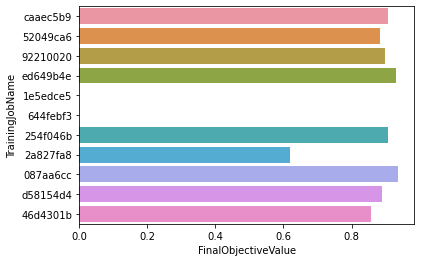

In [119]:
sns.barplot(
    y=hp_results.TrainingJobName.str.split('-').str.get(-1), 
    x=hp_results.FinalObjectiveValue
)

## Evaluate model
### Make predictions
Let's get the test data and get the associated predictions from the Sagemaker endpoint we deployed in the previous step.

In [125]:
from sagemaker.serializers import JSONSerializer

deployed_model = tuner.deploy(
        initial_instance_count=1, instance_type="ml.m5.xlarge", serializer=JSONSerializer()
)


2022-10-18 01:39:31 Starting - Found matching resource for reuse
2022-10-18 01:39:31 Downloading - Downloading input data
2022-10-18 01:39:31 Training - Training image download completed. Training in progress.
2022-10-18 01:39:31 Uploading - Uploading generated training model
2022-10-18 01:39:31 Completed - Resource reused by training job: blazingtext-221018-0120-004-2a827fa8
----!

In [123]:
import json

# Save as np array for easy splitting later
replied_tos = df_test.loc[df_test.target == '__label__reply', 'feature'].values
no_reply = df_test.loc[df_test.target == '__label__no_reply', 'feature'].values

In [126]:
def _prediction_to_df_row(pred: dict) -> dict:
    labels = pred['label']
    probs = pred['prob']
    return {
        label: prob 
        for label, prob in zip(labels, probs)
    }

def get_probs(text: np.array, deployed_model) -> list[np.float]:
    payload = {
        "instances": text,
        "configuration": {"k": 2},  # get probs for top-k (both) classes
    }
    response = deployed_model.predict(payload)
    predictions = json.loads(response)

    all_probs = [
        _prediction_to_df_row(pred) for pred in predictions
    ]
    return pd.DataFrame(all_probs)['__label__reply']

p_reply = get_probs(replied_tos, deployed_model=deployed_model)
p_reply.describe()


count    43.000000
mean     0.686765 
std      0.288802 
min      0.038828 
25%      0.467782 
50%      0.768959 
75%      0.943677 
max      0.999991 
Name: __label__reply, dtype: float64

In [127]:
# Need to make 2 requests
p_no_reply = pd.concat(
    [
        get_probs(no_reply[:2000], deployed_model=deployed_model),
        get_probs(no_reply[2000:], deployed_model=deployed_model)
    ],
    axis=0
)
p_no_reply.describe()

count    3632.000000
mean     0.191807   
std      0.257814   
min      0.000010   
25%      0.020702   
50%      0.056139   
75%      0.261458   
max      0.999732   
Name: __label__reply, dtype: float64

### Model performance

In [128]:
# Vectors of true and predicted scores
y_true = [1] * len(replied_tos) + [0] * len(no_reply)
y_score = p_reply.append(p_no_reply)

y_score.describe()

count    3675.000000
mean     0.197599   
std      0.263585   
min      0.000010   
25%      0.021107   
50%      0.057419   
75%      0.276248   
max      0.999991   
Name: __label__reply, dtype: float64

In [129]:
# AUC
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
roc_auc_score(y_true=y_true, y_score=y_score)

0.8931205819075914

The AUC of .9 is pretty good, but  it can be misleading for an imbalanced classification problem (remember, we only oversampled the training and validation data). Thus, let's look at the confusion matrix for a more detailed view.

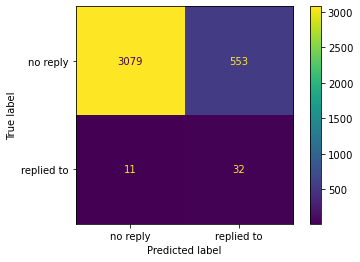

In [130]:
cm = confusion_matrix(y_true=y_true, y_pred=y_score>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no reply', 'replied to'])
disp = disp.plot()
plt.show()

We see that if we just predict the most probable class, we can correctly predict about 60% of replies. This is pretty good for predicting a rare event. Depending on what we care about, we could adjust the prediction threshold. For example, if we care about identifying messages that could potentially require a reply, we could flag each message that has a probability of reply greater than 10%. Let's see what results this gives us:

In [131]:
print(
    classification_report(y_true=y_true, y_pred=y_score>0.5, target_names=['no reply', 'replied to'])
)

              precision    recall  f1-score   support

    no reply       1.00      0.85      0.92      3632
  replied to       0.05      0.74      0.10        43

    accuracy                           0.85      3675
   macro avg       0.53      0.80      0.51      3675
weighted avg       0.99      0.85      0.91      3675



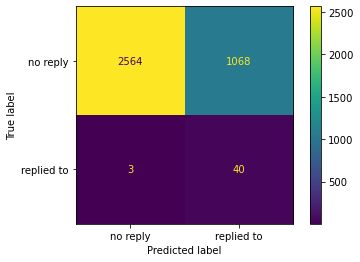

In [143]:
cm = confusion_matrix(y_true=y_true, y_pred=y_score>0.2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no reply', 'replied to'])
disp = disp.plot()
plt.show()

In [145]:
print(
    classification_report(
        y_true=y_true, 
        y_pred=y_score>0.2, 
        target_names=['no reply', 'replied to'])
)

              precision    recall  f1-score   support

    no reply       1.00      0.71      0.83      3632
  replied to       0.04      0.93      0.07        43

    accuracy                           0.71      3675
   macro avg       0.52      0.82      0.45      3675
weighted avg       0.99      0.71      0.82      3675



Now we are able to identify almost all emails eliciting a reply, at the cost of more false positives.

In [ ]:
deployed_model.delete_predictor()

In [ ]:
print(f'Finished at {datetime.now()}')